In [14]:
import os
import sys
from pathlib import Path

In [15]:
# Set up proper directory paths

project_path = Path().absolute().parent
src_path = project_path.joinpath("src")

# Ensure the paths are properly assigned
# If this assertion fails, change project_dir as needed to become the project directory
# If project_dir is correct, change the name in the assertion check
assert project_path.name == "project-athena", "Parent directory name assertion failed (check the path)"

In [16]:
# Add src_dir to module paths
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [17]:
import time

import numpy as np

In [18]:
from matplotlib import pyplot as plt

In [19]:
from attacks.attack import generate
from models.athena import ENSEMBLE_STRATEGY, Ensemble
from utils.data import subsampling
from utils.file import load_from_json, dump_to_json
from utils.metrics import error_rate, get_corrections
from utils.model import load_lenet, load_pool

In [63]:
# copied from tutorials/craft_adversarial_examples.py
def generate_ae(model, data, labels, attack_configs,
                eot=False,
                save=False, output_dir=None):
    """
    Generate adversarial examples
    :param model: WeakDefense. The targeted model.
    :param data: array. The benign samples to generate adversarial for.
    :param labels: array or list. The true labels.
    :param attack_configs: dictionary. Attacks and corresponding settings.
    :param save: boolean. True, if save the adversarial examples.
    :param output_dir: str or path. Location to save the adversarial examples.
        It cannot be None when save is True.
    :return:
    """
    img_rows, img_cols = data.shape[1], data.shape[2]
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # generate attacks one by one
    for id in range(num_attacks):
        key = "configs{}".format(id)
        attack_args = attack_configs.get(key)
        
        description = attack_args['description']
        
        attack_args["eot"] = eot
        
        data_adv = generate(model=model,
                            data_loader=data_loader,
                            attack_args=attack_args)
        
        # predict the adversarial examples
        predictions = model.predict(data_adv)
        predictions = np.asarray([np.argmax(p) for p in predictions])

        err = error_rate(y_pred=predictions, y_true=labels)
        print(">>> error rate:", err)

        # plotting some examples
        num_plotting = min(data.shape[0], 2)
        for i in range(num_plotting):
            img = data_adv[i].reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')
            title = '{}: {}->{}'.format(description,
                                        labels[i],
                                        predictions[i])
            plt.title(title)
            plt.savefig(project_path.joinpath(f"Task1_update/images/{description}-{i}-EOT_{'ON' if eot else 'OFF'}.png"))
            plt.show()
            plt.close()

        # save the adversarial example
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            # save with a random name
            file = os.path.join(output_dir, f"{description}.npy")
            print("Save the adversarial examples to file [{}].".format(file))
            np.save(file, data_adv)

In [55]:
# Load data configs
file = project_path.joinpath("Task1_update/configs/data-mnist.json")
data_configs = load_from_json(file)
model_configs = load_from_json(project_path.joinpath("Task1_update/configs/model-mnist.json"))

# load the benign samples
data_file = project_path.joinpath(data_configs['dir'], data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = project_path.joinpath(data_configs['dir'], data_configs.get('label_file'))
labels = np.load(label_file)

model_file = project_path.joinpath(model_configs['dir'], model_configs['um_file'])
target = load_lenet(file=model_file, wrap=True)

output_path = project_path.joinpath("Task1_update/data/adversary_examples")

>>> Loading model [C:\Users\covin\PycharmProjects\585 Project\project-athena\models\cnn\model-mnist-cnn-clean.h5]...


>>> Generating FGSM_eps0.25(EOT:OFF) examples.
>>> error rate: 0.85


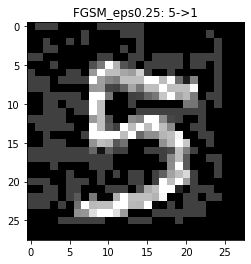

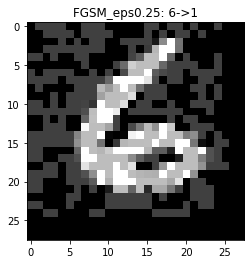

Save the adversarial examples to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task1_update\data\adversary_examples\FGSM_eps0.25.npy].


In [64]:
# EOT OFF
attack_configs = load_from_json(project_path.joinpath("Task1_update/configs/attack-zk-mnist.json"))
generate_ae(model=target, data=data_bs,labels=labels, eot=False, attack_configs=attack_configs,
            save=True, output_dir=output_path)

>>> Generating PGD_eps0.08(EOT:ON) examples.
>>> error rate: 0.02


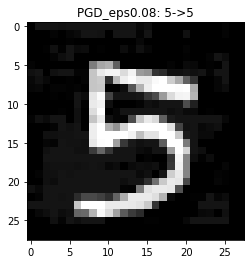

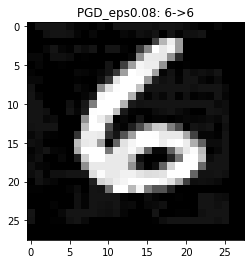

Save the adversarial examples to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task1_update\data\adversary_examples\PGD_eps0.08.npy].
>>> Generating PGD_eps0.12(EOT:ON) examples.


KeyboardInterrupt: 

In [23]:
# EOT ON
attack_configs = load_from_json(project_path.joinpath("Task1_update/configs/attack-zk-mnist-EOT_ON.json"))

# Adaptive approach (with EOT)
# Compute the loss expectation over specific distribution.
# For an ensemble target, averaging the EOT of WDs'.
# let save=True and specify an output folder to save the generated AEs
generate_ae(model=target, data=data_bs, labels=labels, eot=True, attack_configs=attack_configs, save=True, output_dir=output_path)

# Evaluating the generated adverserial example on the vanilla Athena.

In [ ]:
file = project_path.joinpath("Task1_update/configs/data-mnist.json")
data_configs = load_from_json(file)

img_rows, img_cols = data_bs.shape[1], data_bs.shape[2]

pred_bs = target.predict(data_bs)
corrections = get_corrections(y_pred=pred_bs, y_true=labels)

results = {}

ae_files = data_configs.get('task2_aes')

for file in ae_files:
    results[file] = {}
    ae_file = project_path.joinpath(data_configs['dir'], file)
    x_adversarial = np.load(ae_file)
    print(f">>> Running evaluations on [{ae_file}]")
    pred = target.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    print(f">>> Error Rate of {file}: [{err}]")
    results[file] = err
    
result_file = project_path.joinpath("Task2/results/ae_evaluation_results.json")
dump_to_json(results, result_file)
print(f">>> Evaluations on all ae_files dumped to [{result_file}]")

In [12]:
# Running the baseline adversarial examples
file = project_path.joinpath("Task2/configs/data-mnist.json")
data_configs = load_from_json(file)

# load the benign samples
data_file = project_path.joinpath(data_configs['bl_dir'], data_configs.get('all_bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = project_path.joinpath(data_configs['bl_dir'], data_configs.get('all_label_file'))
labels = np.load(label_file)

img_rows, img_cols = data_bs.shape[1], data_bs.shape[2]

pred_bs = target.predict(data_bs)
corrections = get_corrections(y_pred=pred_bs, y_true=labels)

results = {}

ae_files = data_configs.get('ae_files')

for file in ae_files:
    results[file] = {}
    ae_file = project_path.joinpath(data_configs['bl_dir'], file)
    x_adversarial = np.load(ae_file)
    print(f">>> Running evaluations on [{ae_file}]")
    pred = target.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    print(f">>> Error Rate of {file}: [{err}]")
    results[file] = err
    
result_file = project_path.joinpath("Task2/results/baseline_ae_evaluation_results.json")
dump_to_json(results, result_file)
print(f">>> Evaluations on all ae_files dumped to [{result_file}]")

>>> Running evaluations on [D:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.1.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.1.npy: [0.25148974851025147]
>>> Running evaluations on [D:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.15.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.15.npy: [0.5145944854055146]
>>> Running evaluations on [D:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.2.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.2.npy: [0.711948288051712]
>>> Running evaluations on [D:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.25.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.25.npy: [0.8253711746288254]
>>> Running evaluations on [D:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-fgsm_eps0.3.npy]
>>> Error Rate of test_AE-mnist-cnn-clean-fgsm_eps0.3.npy: [0.8842541157458843]
>>> Running evaluations on [D:\GitHub\project-athena\data\test_AE-mnist-cnn-clean-bim_ord2_eps0.75.np